<a href="https://colab.research.google.com/github/VinamraOberoi/PSO-algorithm-for-DTIoV/blob/main/PSO_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install folium
# !pip install geopandas

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# Simulated street grid for Delhi with coordinates (for RSU and MBS positions)
# # Representing as (x, y) coordinates on a simplified grid.
# delhi_streets_grid = {
#     "Vehicle_Locations": [(1, 2), (2, 4), (3, 6), (4, 5), (6, 8), (5, 10)],  # Vehicle positions
#     "RSU_Locations": [(2, 3), (4, 6), (6, 7)],  # RSU positions on Delhi streets
#     "MBS_Locations": [(3, 3), (5, 5)],  # MBS positions in Delhi
#     "Cloud_Location": (10, 10)  # Cloud server assumed to be offsite
# }

In [4]:
# delhi_streets_grid = {
#     # Simulated Vehicle Locations across Delhi (approx. lat/lon coordinates)
#     "Vehicle_Locations": [
#         [28.7041, 77.1025], [28.6139, 77.2090], [28.5355, 77.3910], [28.4595, 77.0266], 
#         [28.4089, 77.3178], [28.6663, 77.2111], [28.6692, 77.4538], [28.6290, 77.2167], 
#         [28.6219, 77.3095], [28.6745, 77.1100], [28.6358, 77.2244], [28.7041, 77.2157],
#         [28.5489, 77.2682], [28.6471, 77.2152], [28.5272, 77.2902], [28.6304, 77.0983],
#         [28.5540, 77.3386], [28.4500, 77.5183], [28.7321, 77.1000], [28.5966, 77.3181]
#     ],
    
#     # Simulated RSU Locations (Roadside Units spread across Delhi)
#     "RSU_Locations": [
#         [28.6846, 77.2026], [28.5353, 77.3075], [28.6132, 77.2086], [28.7042, 77.2001], 
#         [28.4797, 77.3357], [28.6212, 77.2342], [28.6324, 77.0954], [28.5792, 77.3119],
#         [28.6620, 77.1720], [28.6587, 77.2413], [28.5457, 77.3026], [28.6017, 77.2591],
#         [28.7130, 77.1914], [28.5014, 77.4102], [28.5500, 77.2900], [28.7043, 77.1791],
#         [28.6096, 77.2507], [28.5324, 77.2856], [28.6273, 77.2752], [28.4753, 77.2765]
#     ],
    
#     # Simulated MBS Locations (Macro Base Stations across Delhi)
#     "MBS_Locations": [
#         [28.7041, 77.1025], [28.4595, 77.0266], [28.5355, 77.3910], [28.6139, 77.2090], 
#         [28.4089, 77.3178], [28.5353, 77.3075], [28.6846, 77.2026], [28.6290, 77.2167],
#         [28.6450, 77.3000], [28.6547, 77.2042], [28.6034, 77.2394], [28.6753, 77.1812]
#     ],
    
#     # Cloud Location fixed in Connaught Place, Delhi
#     "Cloud_Location": [28.6139, 77.2090]
# }


In [5]:
# # Correct function to generate random latitude and longitude within Delhi's actual bounding box
# def generate_random_lat_lon_in_delhi(num_points, lat_range=(28.40, 28.88), lon_range=(76.84, 77.35)):
#     return [[random.uniform(lat_range[0], lat_range[1]), random.uniform(lon_range[0], lon_range[1])] for _ in range(num_points)]

# # Simulating the dataset for 1000 vehicles, 100 RSUs, and 20 MBSs in Delhi
# delhi_streets_grid = {
#     # 1000 Vehicle Locations spread across Delhi
#     "Vehicle_Locations": generate_random_lat_lon_in_delhi(1000),

#     # 100 RSU Locations (Roadside Units spread across Delhi)
#     "RSU_Locations": generate_random_lat_lon_in_delhi(100),

#     # 20 MBS Locations (Macro Base Stations spread across Delhi)
#     "MBS_Locations": generate_random_lat_lon_in_delhi(20),

#     # Cloud Location fixed in Connaught Place, Delhi (center)
#     "Cloud_Location": [28.6139, 77.2090]  # Cloud server at Connaught Place, central Delhi
# }

# # Output the size of each dataset for verification
# print(f"Number of Vehicles: {len(delhi_streets_grid['Vehicle_Locations'])}")
# print(f"Number of RSUs: {len(delhi_streets_grid['RSU_Locations'])}")
# print(f"Number of MBSs: {len(delhi_streets_grid['MBS_Locations'])}")


In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Load the GeoJSON file for Delhi (you need a file containing Delhi's boundaries in GeoJSON format)
# You can download a GeoJSON of Delhi from sources like https://geojson-maps.ash.ms or use a custom one.
geojson_file = 'delhi_boundary.geojson'

# Load Delhi boundaries using GeoPandas
delhi_gdf = gpd.read_file(geojson_file)

# Extract the polygon boundary of Delhi
delhi_polygon = delhi_gdf['geometry'].values[0]  # Assuming only one polygon for Delhi

# Function to generate random points within the Delhi polygon
def generate_random_points_within_polygon(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds  # Bounding box of the polygon
    while len(points) < num_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):  # Ensure the point is within the polygon
            points.append([random_point.y, random_point.x])  # Add (latitude, longitude) for consistency
    return points

# Generate the datasets
num_vehicles = 1000
num_rsus = 100
num_mbs = 20

delhi_streets_grid = {
    # Generate 1000 Vehicle Locations within Delhi
    "Vehicle_Locations": generate_random_points_within_polygon(delhi_polygon, num_vehicles),

    # Generate 100 RSU Locations within Delhi
    "RSU_Locations": generate_random_points_within_polygon(delhi_polygon, num_rsus),

    # Generate 20 MBS Locations within Delhi
    "MBS_Locations": generate_random_points_within_polygon(delhi_polygon, num_mbs),

    # Cloud Location fixed in Connaught Place, Delhi
    "Cloud_Location": [28.6139, 77.2090]  # Cloud server at Connaught Place, central Delhi
}

# Display the number of points generated
print(f"Number of Vehicles: {len(delhi_streets_grid['Vehicle_Locations'])}")
print(f"Number of RSUs: {len(delhi_streets_grid['RSU_Locations'])}")
print(f"Number of MBSs: {len(delhi_streets_grid['MBS_Locations'])}")

Number of Vehicles: 1000
Number of RSUs: 100
Number of MBSs: 20


In [7]:
# PSO Hyperparameters (variable swarm size)
swarm_sizes = [10, 30, 50, 100]  # Different numbers of particles to test
num_iterations = 200  # Number of iterations
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive parameter (particle's own best)
c2 = 1.5  # Social parameter (swarm's global best)

In [8]:
# System Parameters for IoV
num_tasks = 150  # Number of tasks generated by vehicles
num_options = 4  # Task allocation choices: 0=Local, 1=RSU, 2=MBS, 3=Cloud
cloud_latency = 100  # Cloud processing latency in ms
mbs_latency = 50  # MBS processing latency in ms
rsu_latency = 30  # RSU processing latency in ms
local_latency = 10  # Local processing latency in ms

In [9]:
# Task sizes and latencies (for simplicity, random values)
task_sizes = np.random.uniform(0.5, 5, num_tasks)  # Task size in MB
task_latencies = np.random.uniform(10, 100, num_tasks)  # Task latency in ms

In [10]:
# Distance-based latency function (distance between vehicles and RSUs/MBSs/Cloud on grid)
def calculate_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

In [11]:
# Function to compute latency based on allocation and vehicle distance from RSUs, MBS, and Cloud
def compute_latency(position):
    total_latency = 0
    print(f"Number of tasks: {len(position)}") # Check the number of tasks
    print(f"Number of vehicle locations: {len(delhi_streets_grid['Vehicle_Locations'])}") # Check the number of vehicle locations
    for i, allocation in enumerate(position):
        # Use modulo operator to ensure index is within bounds of vehicle locations
        vehicle_location = delhi_streets_grid["Vehicle_Locations"][i % len(delhi_streets_grid["Vehicle_Locations"])]
        if allocation == 0:  # Local processing
            total_latency += local_latency
        elif allocation == 1:  # RSU processing
            rsu_location = random.choice(delhi_streets_grid["RSU_Locations"])  # Choose nearest RSU (simplified)
            distance = calculate_distance(vehicle_location, rsu_location)
            total_latency += rsu_latency + distance  # Add latency based on distance
        elif allocation == 2:  # MBS processing
            mbs_location = random.choice(delhi_streets_grid["MBS_Locations"])  # Choose nearest MBS
            distance = calculate_distance(vehicle_location, mbs_location)
            total_latency += mbs_latency + distance  # Add latency based on distance
        elif allocation == 3:  # Cloud processing
            cloud_location = delhi_streets_grid["Cloud_Location"]
            distance = calculate_distance(vehicle_location, cloud_location)
            total_latency += cloud_latency + distance  # Cloud latency + distance
    return total_latency

In [12]:
# Function to compute system throughput based on task allocation
def compute_throughput(position):
    total_throughput = 0
    for i, allocation in enumerate(position):
        task_size = task_sizes[i]
        if allocation == 0:  # Local processing
            total_throughput += task_size / local_latency
        elif allocation == 1:  # RSU processing
            total_throughput += task_size / rsu_latency
        elif allocation == 2:  # MBS processing
            total_throughput += task_size / mbs_latency
        elif allocation == 3:  # Cloud processing
            total_throughput += task_size / cloud_latency
    return total_throughput

In [13]:
# Fitness function (combining latency and throughput based on paper)
def fitness_function(position):
    latency = compute_latency(position)  # Calculate latency based on task allocation
    throughput = compute_throughput(position)  # Calculate throughput based on task allocation
    return 0.5 * latency + 0.5 * (1 / throughput)  # Combine latency and throughput into a fitness score

In [14]:
# Store best fitness values over iterations for each swarm size
fitness_history = {}


Running PSO with 10 particles...

Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of

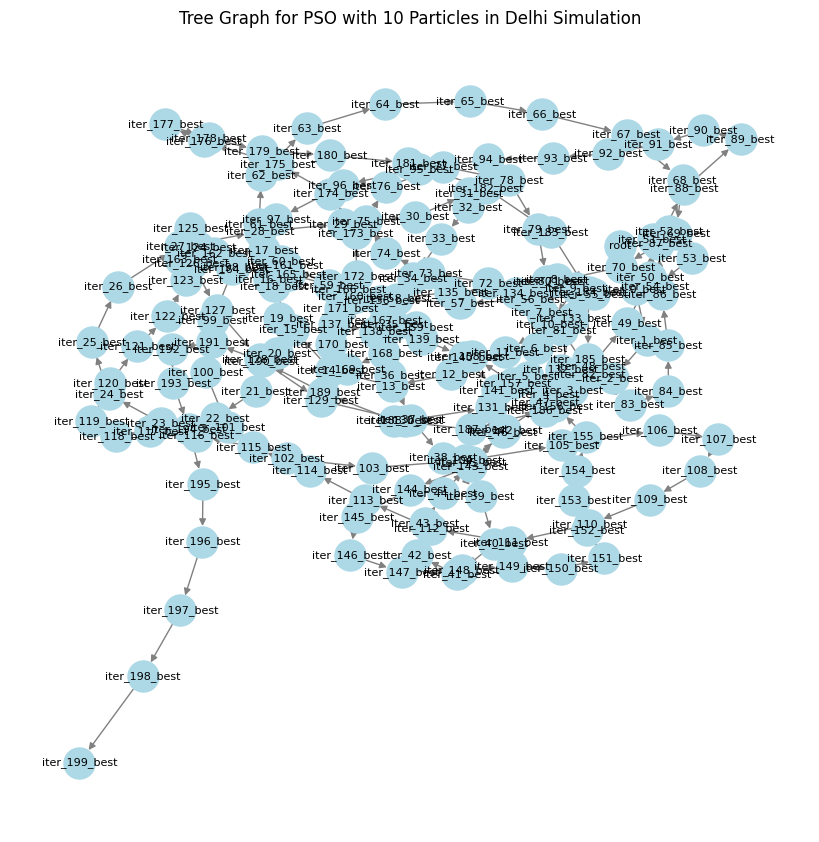


Running PSO with 30 particles...

Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of

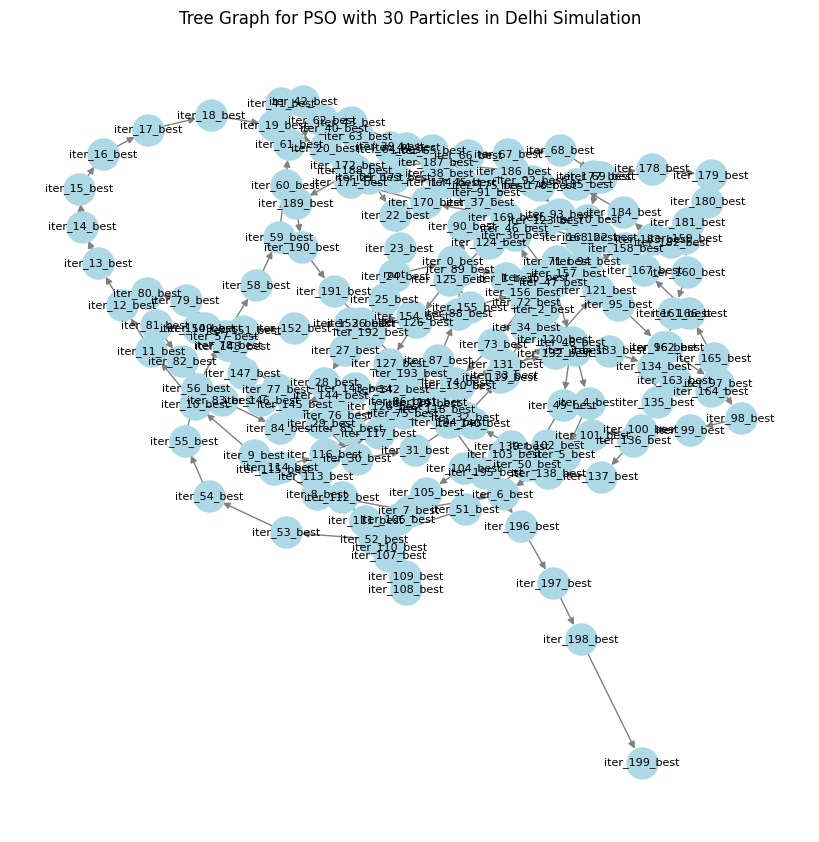


Running PSO with 50 particles...

Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of

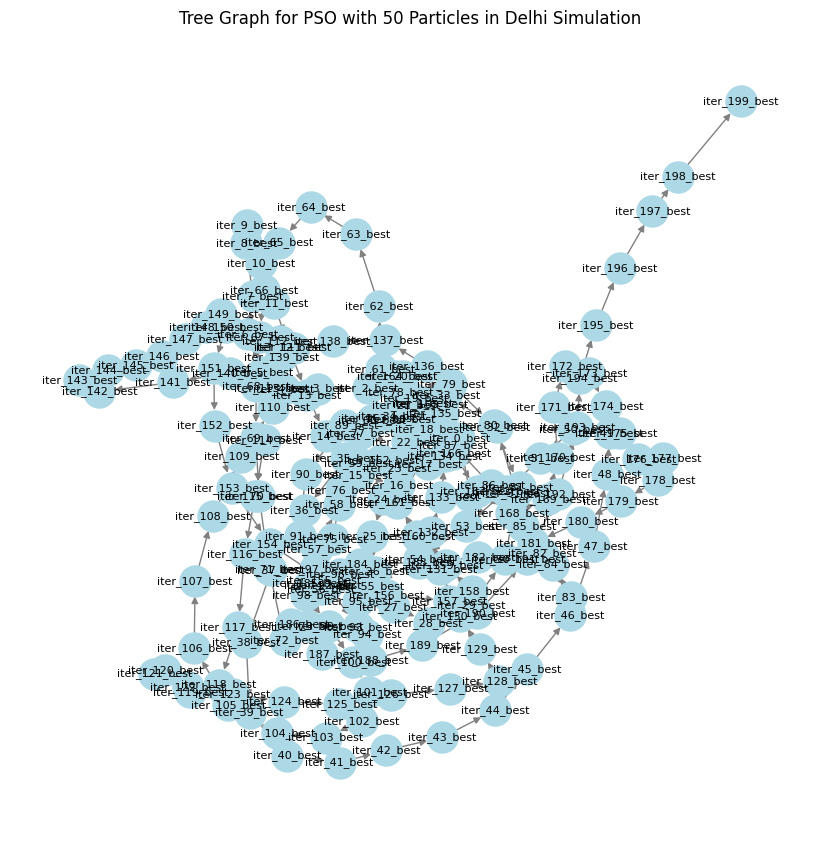


Running PSO with 100 particles...

Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number of vehicle locations: 1000
Number of tasks: 150
Number o

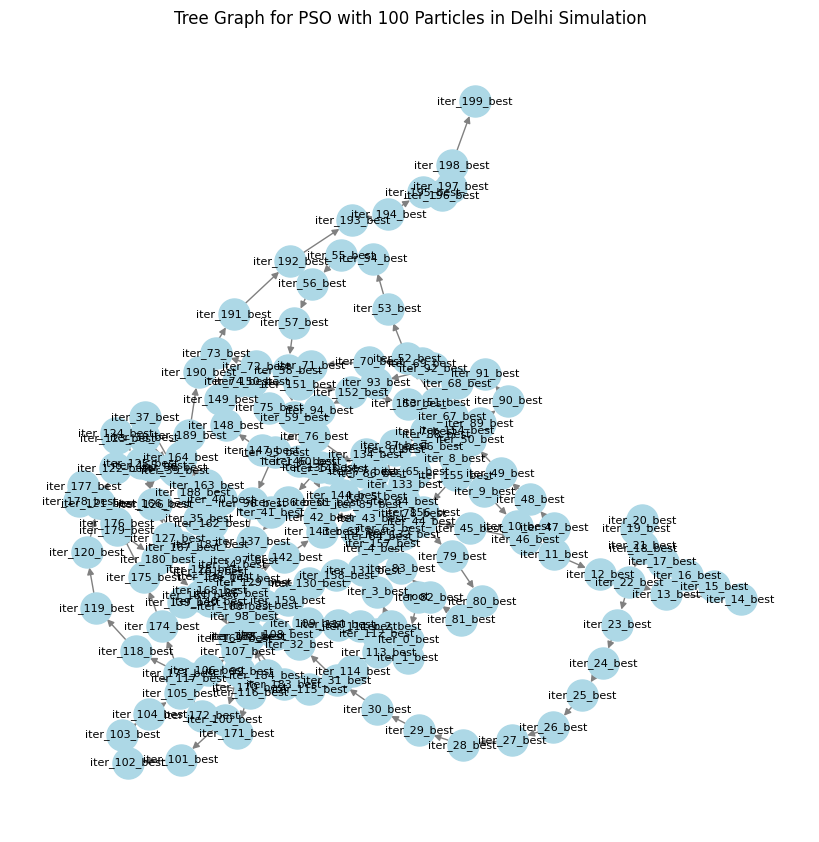

In [15]:
# Run PSO for multiple swarm sizes
for num_particles in swarm_sizes:
    print(f"\nRunning PSO with {num_particles} particles...\n")

    # Initialize particle positions (task allocation) and velocities
    particles_position = np.random.randint(0, num_options, size=(num_particles, num_tasks))  # Random allocation
    particles_velocity = np.random.uniform(-1, 1, (num_particles, num_tasks))

    # Initialize personal best and global best positions
    personal_best_position = np.copy(particles_position)
    personal_best_fitness = np.inf * np.ones(num_particles)
    global_best_position = None
    global_best_fitness = np.inf

    # Create a tree graph to track solution evolution
    G = nx.DiGraph()  # Directed graph for particle evolution tree
    root_node = "root"  # Initial node of the tree
    G.add_node(root_node)

    # Keep track of best fitness over iterations
    best_fitness_per_iteration = []

    # PSO Algorithm
    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Compute fitness for the current particle position
            current_fitness = fitness_function(particles_position[i])

            # Update personal best for the particle
            if current_fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = current_fitness
                personal_best_position[i] = np.copy(particles_position[i])

            # Update global best for the swarm
            if current_fitness < global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = np.copy(particles_position[i])

        # Track the best fitness found at this iteration
        best_fitness_per_iteration.append(global_best_fitness)

        # Update velocities and positions for each particle
        for i in range(num_particles):
            r1 = np.random.rand(num_tasks)  # Random numbers for cognitive component
            r2 = np.random.rand(num_tasks)  # Random numbers for social component

            # Update velocity (inertia + cognitive + social components)
            particles_velocity[i] = (w * particles_velocity[i] +
                                     c1 * r1 * (personal_best_position[i] - particles_position[i]) +
                                     c2 * r2 * (global_best_position - particles_position[i]))

            # Update particle position (ensure task allocation remains discrete)
            particles_position[i] = particles_position[i].astype(float) + particles_velocity[i]
            particles_position[i] = np.clip(np.round(particles_position[i]), 0, num_options - 1).astype(int) # Ensure allocation is between 0 and 3

        # Add nodes and edges to the tree for this iteration (evolution of the best solution)
        iteration_node = f"iter_{iteration}_best"
        G.add_node(iteration_node)
        G.add_edge(root_node, iteration_node)
        root_node = iteration_node  # Move the root for the next iteration

    # Store the fitness history for this swarm size
    fitness_history[num_particles] = best_fitness_per_iteration

    # Final output: the optimal task allocation strategy for current swarm size
    print(f"\nOptimal Task Allocation for {num_particles} particles: {global_best_position}")
    print(f"Optimal Fitness (Latency + Throughput) for {num_particles} particles: {global_best_fitness}")

    # Plot the tree graph for this PSO run
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8, font_color='black')
    plt.title(f'Tree Graph for PSO with {num_particles} Particles in Delhi Simulation')
    plt.show()

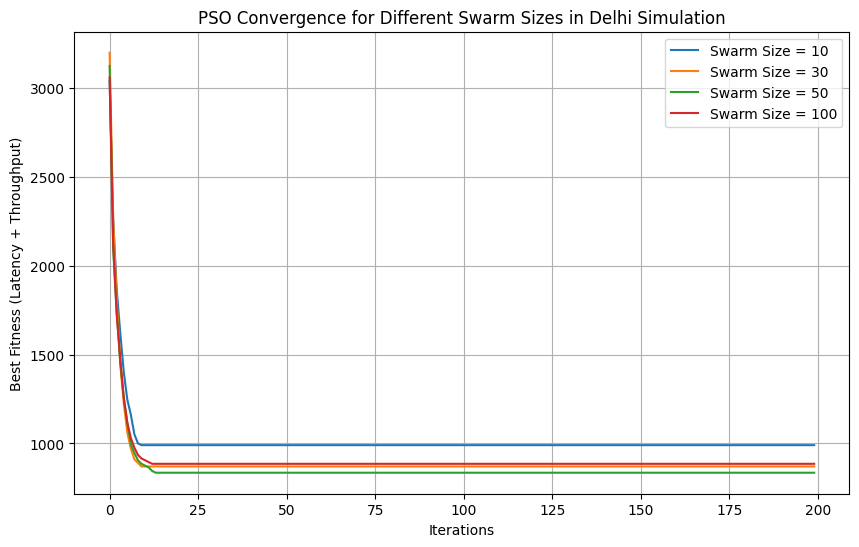

In [16]:
# Plotting the PSO results
plt.figure(figsize=(10, 6))
for num_particles in swarm_sizes:
    plt.plot(range(num_iterations), fitness_history[num_particles], label=f'Swarm Size = {num_particles}')

plt.title('PSO Convergence for Different Swarm Sizes in Delhi Simulation')
plt.xlabel('Iterations')
plt.ylabel('Best Fitness (Latency + Throughput)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [17]:
import folium

# Create a map centered around a specific location in Delhi (assuming coordinates)
map_center = [28.6139, 77.2090]  # Delhi's latitude and longitude
m = folium.Map(location=map_center, zoom_start=12, tiles=None)  # Start with no base layer

# Add a satellite overlay layer (ESRI World Imagery or Google Satellite)
folium.TileLayer('Esri.WorldImagery').add_to(m)  # Satellite imagery

# Add vehicle locations
for coord in delhi_streets_grid["Vehicle_Locations"]:
    folium.Marker(
        location=[map_center[0] + coord[0] * 0.01, map_center[1] + coord[1] * 0.01],
        popup="Vehicle",
        icon=folium.Icon(color='blue', icon='car', prefix='fa')
    ).add_to(m)

# Add RSU locations
for coord in delhi_streets_grid["RSU_Locations"]:
    folium.Marker(
        location=[map_center[0] + coord[0] * 0.01, map_center[1] + coord[1] * 0.01],
        popup="RSU",
        icon=folium.Icon(color='green', icon='signal', prefix='fa')
    ).add_to(m)

# Add MBS locations
for coord in delhi_streets_grid["MBS_Locations"]:
    folium.Marker(
        location=[map_center[0] + coord[0] * 0.01, map_center[1] + coord[1] * 0.01],
        popup="MBS",
        icon=folium.Icon(color='red', icon='broadcast-tower', prefix='fa')
    ).add_to(m)

# Add Cloud location (offsite)
cloud_location = delhi_streets_grid["Cloud_Location"]
folium.Marker(
    location=[map_center[0] + cloud_location[0] * 0.01, map_center[1] + cloud_location[1] * 0.01],
    popup="Cloud Server",
    icon=folium.Icon(color='purple', icon='cloud', prefix='fa')
).add_to(m)

# Add a Layer Control to toggle between different layers
folium.LayerControl().add_to(m)

# Save map to HTML
m.save("delhi_map_with_satellite_overlay.html")

# Display the map in the notebook (optional if running in Jupyter)
m
